In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataDir = "longrun"

## All run subfolders assumed to be in directory [dataDir] that does not contain anything else

In [3]:
acc_results = {}
loss_results = {}
# List files in data:
from os import listdir
for folder in listdir(dataDir):
    print folder
    acc_results[folder] = []
    loss_results[folder] = []
    for filename in listdir(dataDir+'/'+folder):
        if filename != 'ps.out':
            with open(dataDir+"/"+folder+"/"+filename, "r") as f:
                for line in f.readlines():
                    if line.startswith("INFO:tensorflow:Step:"):
                        parts = line.split(" ")
                        step = int(parts[1][:-1])
                        if step > 5000:
                            break
                        accuracy = float(parts[3][:-1])
                        loss = float(parts[5])
                        acc_results[folder].append((step, accuracy))
                        loss_results[folder].append((step, loss))

for key, val in acc_results.items():
    val.sort()
    acc_results[key] = [y for x,y in val]
for key, val in loss_results.items():
    val.sort()
    loss_results[key] = [y for x,y in val]

LongRun-16-0.0005--0.3-False
LongRun-16-0.0005-0.0-False
LongRun-16-0.0005-0.3-False
LongRun-16-0.0005-0.3-True
LongRun-16-0.0005-0.6-True
LongRun-16-0.0005-0.9-True
LongRun-16-0.001--0.3-False
LongRun-16-0.001-0.0-False
LongRun-16-0.001-0.3-False
LongRun-16-0.001-0.3-True
LongRun-16-0.001-0.6-True
LongRun-16-0.001-0.9-True
LongRun-16-0.005--0.3-False
LongRun-16-0.005-0.0-False
LongRun-16-0.005-0.3-False
LongRun-16-0.005-0.3-True
LongRun-16-0.005-0.6-True
LongRun-16-0.005-0.9-True


In [4]:
def moving_average2(signal, window_size=100):
    window = np.ones(int(window_size))/float(window_size)
    conv = np.convolve(signal, window, 'same')
    conv = np.convolve(conv, window, 'same')[:-window_size]
    conv[:window_size] = np.nan
    return conv

In [5]:
def moving_average1(signal, window_size=100):
    window = np.ones(int(window_size))/float(window_size)
    conv = np.convolve(signal, window, 'same')[:-window_size//2]
    conv[:window_size//2] = np.nan
    return conv

### Set sizes of two windows used for smoothing

In [52]:
WINDOW = 350

### Finds best runs after smoothing loss

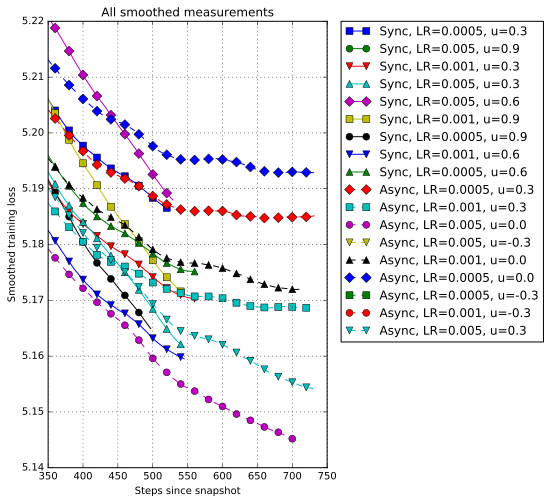

In [53]:
best_async = None
best_sync = None
async_keeper = None
sync_keeper = None

plt.figure(figsize=(5,8))

import itertools
#marker = itertools.cycle(('s', 'o', 'v', '^', '*', 'p', 'D', 'H')) 
marker = itertools.cycle(('s', 'o', 'v', '^', 'D')) 


for folder, loss in loss_results.items():
    folderParts = folder.split('-')
    LR = folderParts[2]
    if len(folderParts[3])==0:
        mom = '-' + folderParts[4]
    else:
        mom = folderParts[3]
 
    if "True" in folder:
        #avg = moving_average2(loss,WINDOW)
        avg = moving_average2(loss,WINDOW)
        if avg[-1] < sync_keeper or sync_keeper is None:
            sync_keeper = avg[-1]
            best_sync = avg
            best_sync_name = folder
            #print folder
        plt.plot(avg, markersize=7, marker = marker.next(), markevery=20, label='Sync, LR='+str(LR)+', u='+str(mom))
for folder, loss in loss_results.items():
    folderParts = folder.split('-')
    LR = folderParts[2]
    if len(folderParts[3])==0:
        mom = '-' + folderParts[4]
    else:
        mom = folderParts[3]
    if "False" in folder:
        #avg = moving_average2(loss,WINDOW)
        avg = moving_average2(loss,WINDOW)

        if avg[-1] < async_keeper or async_keeper is None:
            async_keeper = avg[-1]
            best_async = avg
            best_async_name = folder
            #print folder
        plt.plot(avg, markersize=7, linestyle='--', marker = marker.next(), markevery=20, label='Async, LR='+str(LR)+', u='+str(mom))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.axis([None,None,5.14,5.22]);
plt.xlabel('Steps since snapshot')
plt.ylabel('Smoothed training loss');
plt.title('All smoothed measurements');

### Plot winning curves along with evaluation loss level 

In [45]:
s = best_sync.copy()
a = best_async.copy()

min_s = min(s[WINDOW:])
min_a = min(a[WINDOW:])
target = max(min_s, min_a)

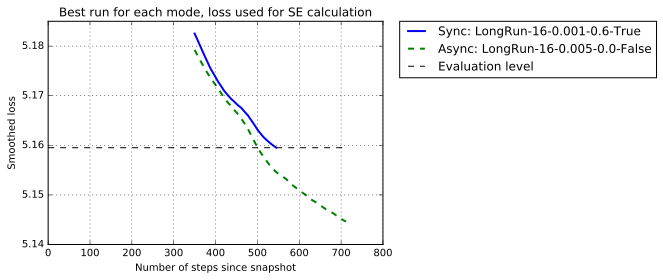

In [46]:
plt.plot(s, linewidth=2)
plt.plot(a, '--', linewidth=2)
plt.plot([0,np.max([len(s),len(a)])],2*[target],'--k')
plt.xlabel('Number of steps since snapshot')
plt.ylabel('Smoothed loss')
plt.legend(['Sync: ' + best_sync_name, 'Async: ' + best_async_name, 'Evaluation level'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title('Best run for each mode, loss used for SE calculation')
plt.grid()

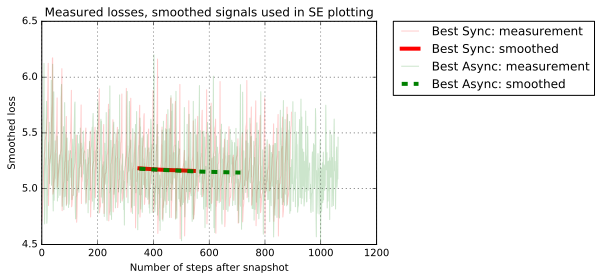

In [47]:
plt.plot(loss_results[best_sync_name],'r',alpha=0.2)
plt.plot(s,'r',linewidth=4)
plt.plot(loss_results[best_async_name],'g',alpha=0.2)
plt.plot(a,'--g',linewidth=4)

plt.xlabel('Number of steps after snapshot')
plt.ylabel('Smoothed loss')
plt.legend(['Best Sync: measurement', 'Best Sync: smoothed','Best Async: measurement', 'Best Async: smoothed'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title('Measured losses, smoothed signals used in SE plotting')
plt.grid()

# Plot HE-SE

## Enter batch time averages here

In [11]:
SYNC_SECONDS_PER_BATCH = 24

In [12]:
ASYNC_SECONDS_PER_BATCH = 20

In [13]:
CG = 16

In [ ]:
async_meets_target = np.argmax(a <= target)
sync_meets_target = np.argmax(s <= target)

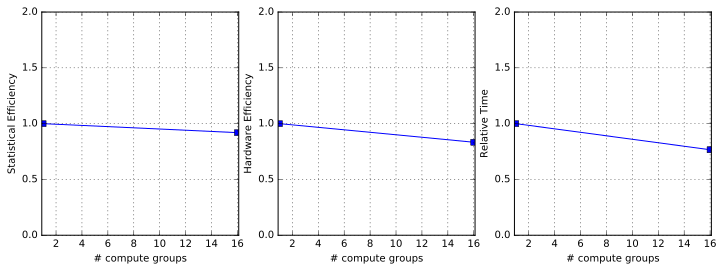

In [15]:
SE = np.array([sync_meets_target,async_meets_target])/float(sync_meets_target)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.plot([1,CG],SE, '-s')
ax1.set_ylabel('Statistical Efficiency')
ax1.set_xlabel('# compute groups')
ax1.grid()
ax1.axis([0.9,CG+.1, 0, 2])

# Hardware efficiency
sync_time_per_iter = SYNC_SECONDS_PER_BATCH

async_time_per_iter = ASYNC_SECONDS_PER_BATCH


async_time_per_iter / sync_time_per_iter

HE = np.array([sync_time_per_iter,async_time_per_iter])/float(sync_time_per_iter)

ax2.plot([1,CG],HE, '-s')
ax2.set_ylabel('Hardware Efficiency')
ax2.set_xlabel('# compute groups')
ax2.grid()
ax2.axis([0.9,CG+.1, 0, 2])


ax3.plot([1,CG],np.multiply(HE,SE), '-s')
ax3.set_ylabel('Relative Time')
ax3.set_xlabel('# compute groups')
ax3.grid()
ax3.axis([0.9,CG+.1, 0, 2]);

In [16]:
f.savefig('experiment4-se-he.png', bbox_inches='tight', pad_inches=0.1)

In [17]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [19]:
window_size = 5

In [20]:
window = np.ones(int(window_size))/float(window_size)

In [35]:
window = np.concatenate((window,np.zeros(32-len(window))),axis=0)

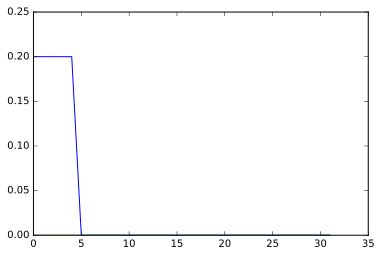

In [36]:
conv = np.convolve(window,window,'SAME')

plt.plot(window)
plt.plot(conv)

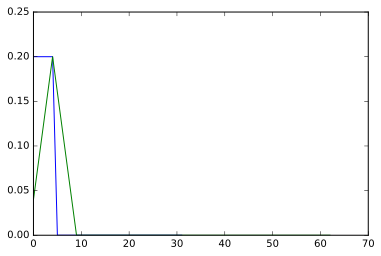

In [37]:
conv = np.convolve(window,window)

plt.plot(window)
plt.plot(conv)

In [25]:
sum(conv)

1.0000000000000002

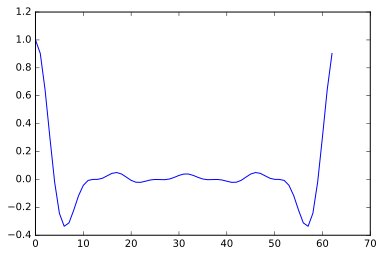

In [38]:
plt.plot(np.fft.fft(conv))

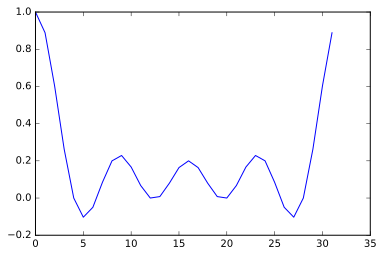

In [39]:
plt.plot(np.fft.fft(window))